In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [18]:
df = pd.read_csv("../Data/flight_dep_classi_tree.csv")
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45155 entries, 0 to 45154
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MONTH                      45155 non-null  int64  
 1   DAY_OF_MONTH               45155 non-null  int64  
 2   DAY_OF_WEEK                45155 non-null  int64  
 3   CRS_DEP_TIME               45155 non-null  float64
 4   CRS_ELAPSED_TIME           45155 non-null  float64
 5   OP_UNIQUE_CARRIER          45155 non-null  int64  
 6   ORIGIN                     45155 non-null  int64  
 7   DEST                       45155 non-null  int64  
 8   DISTANCE                   45155 non-null  float64
 9   HourlyDewPointTemperature  45155 non-null  float64
 10  HourlyDryBulbTemperature   45155 non-null  float64
 11  HourlyRelativeHumidity     45155 non-null  float64
 12  HourlyVisibility           45155 non-null  float64
 13  HourlyWindSpeed            45155 non-null  flo

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,CRS_ELAPSED_TIME,OP_UNIQUE_CARRIER,ORIGIN,DEST,DISTANCE,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyVisibility,HourlyWindSpeed,DEP_DEL15
count,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000
mean,5.046728,15.877489,3.971321,13.585353,183.310597,4.342642,3.611007,45.445288,1175.492703,42.800066,59.471664,57.692747,9.810818,8.246529,0.117418
std,0.808438,8.780866,2.005020,5.287004,84.569100,3.858876,0.992802,25.759279,732.185970,6.723190,9.337098,18.536586,0.983229,3.873726,0.321921
min,4.000000,1.000000,1.000000,0.080000,49.000000,0.000000,0.000000,0.000000,93.000000,5.000000,30.000000,11.000000,0.000000,0.000000,0.000000
25%,4.000000,8.000000,2.000000,9.080000,125.000000,1.000000,4.000000,22.000000,679.000000,39.000000,53.000000,44.000000,10.000000,6.000000,0.000000
50%,5.000000,16.000000,4.000000,12.970000,166.000000,3.000000,4.000000,45.000000,978.000000,43.000000,58.000000,59.000000,10.000000,8.000000,0.000000
75%,6.000000,23.000000,6.000000,17.900000,244.000000,9.000000,4.000000,71.000000,1721.000000,48.000000,65.000000,71.000000,10.000000,10.000000,0.000000
max,6.000000,31.000000,7.000000,23.980000,411.000000,11.000000,4.000000,85.000000,2724.000000,60.000000,102.000000,100.000000,10.000000,30.000000,1.000000


In [19]:
X = df.drop(columns=["DEP_DEL15"])
y = df["DEP_DEL15"]

In [20]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (27093, 14), Val: (9031, 14), Test: (9031, 14)


In [21]:
models = {
    "Random Forest": RandomForestClassifier(
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "XGBoost": xgb.XGBClassifier(
        eval_metric="logloss", scale_pos_weight=5, random_state=42, n_jobs=-1
    ),
    "LightGBM": lgb.LGBMClassifier(
        is_unbalance=True, random_state=42, n_jobs=-1
    ),
}

In [22]:
param_grids = {
    "Random Forest": {
        "n_estimators": [200, 400],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"],
    },
    "XGBoost": {
        "n_estimators": [200, 400],
        "max_depth": [5, 8, 12],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "gamma": [0, 1],
    },
    "LightGBM": {
        "n_estimators": [200, 400],
        "num_leaves": [31, 63, 127],
        "learning_rate": [0.05, 0.1],
        "feature_fraction": [0.8, 1.0],
        "bagging_fraction": [0.8, 1.0],
        "min_child_samples": [20, 50],
    },
}

In [23]:
results = []

for name, model in models.items():
    print(f"\n{'='*65}\n Training {name}\n{'='*65}")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=3,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_val_pred = best_model.predict(X_val)
    y_val_prob = best_model.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, y_val_prob)
    f1 = f1_score(y_val, y_val_pred)
    acc = accuracy_score(y_val, y_val_pred)

    print(f" Best Params: {grid.best_params_}")
    print(f"Validation ROC-AUC: {roc_auc:.4f}, F1: {f1:.4f}, Acc: {acc:.4f}")

    results.append({
        "Model": name,
        "ROC-AUC": roc_auc,
        "F1": f1,
        "Accuracy": acc,
        "Best Params": grid.best_params_,
        "Best Model": best_model
    })


 Training Random Forest
Fitting 3 folds for each of 108 candidates, totalling 324 fits
 Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}
Validation ROC-AUC: 0.6956, F1: 0.2876, Acc: 0.6747

 Training XGBoost
Fitting 3 folds for each of 96 candidates, totalling 288 fits
 Best Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Validation ROC-AUC: 0.7071, F1: 0.3055, Acc: 0.7598

 Training LightGBM
Fitting 3 folds for each of 96 candidates, totalling 288 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagg


 Validation Results:
           Model   ROC-AUC        F1  Accuracy  \
1        XGBoost  0.707051  0.305476  0.759827   
2       LightGBM  0.705115  0.301364  0.659617   
0  Random Forest  0.695590  0.287585  0.674676   

                                         Best Params  
1  {'colsample_bytree': 0.8, 'gamma': 1, 'learnin...  
2  {'bagging_fraction': 0.8, 'feature_fraction': ...  
0  {'max_depth': 10, 'max_features': 'sqrt', 'min...  


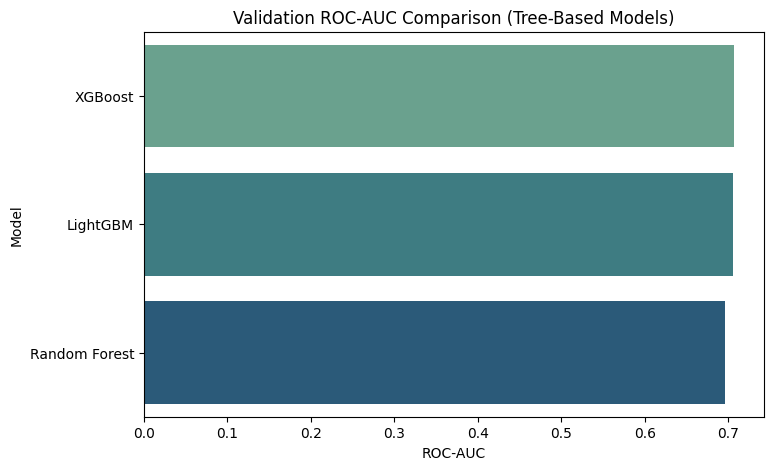

In [24]:
results_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)
print("\n Validation Results:")
print(results_df[["Model", "ROC-AUC", "F1", "Accuracy", "Best Params"]])

plt.figure(figsize=(8,5))
sns.barplot(x="ROC-AUC", y="Model", data=results_df, palette="crest")
plt.title("Validation ROC-AUC Comparison (Tree-Based Models)")
plt.show()

In [25]:
best_row = results_df.iloc[0]
final_model = best_row["Best Model"]
print(f"\n Final Model: {best_row['Model']}")

# Retrain on Train + Val
final_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]

roc_auc_test = roc_auc_score(y_test, y_test_prob)
f1_test = f1_score(y_test, y_test_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print("\n FINAL TEST PERFORMANCE")
print(f"ROC-AUC: {roc_auc_test:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"Accuracy: {acc_test:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


 Final Model: XGBoost

 FINAL TEST PERFORMANCE
ROC-AUC: 0.7262
F1: 0.3340
Accuracy: 0.7743

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86      7971
         1.0       0.26      0.48      0.33      1060

    accuracy                           0.77      9031
   macro avg       0.59      0.65      0.60      9031
weighted avg       0.84      0.77      0.80      9031



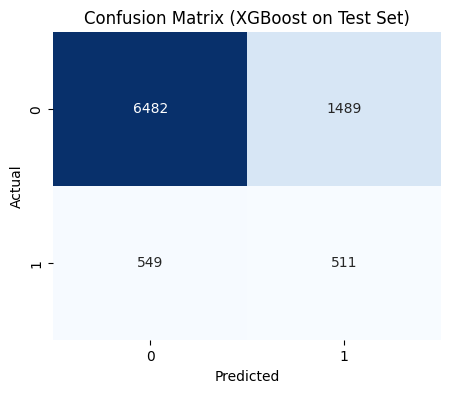

In [26]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_test_pred),
            annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix ({best_row['Model']} on Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()